                                                       OM

In [1649]:
!pip3 install wordcloud
!pip3 install swifter
!pip3 install gensim
!python -m pip3 install imbalanced-learn
!pip3 install xgboost

/Users/sunilshivaswamy/anaconda3/bin/python: No module named pip3


In [1650]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1651]:
import re
import nltk
import pickle
import swifter
import string
import gensim
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sunilshivaswamy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sunilshivaswamy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1652]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB

import xgboost as xgb
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, precision_score, recall_score, confusion_matrix

In [1653]:
# Old version - 0.24.1
sklearn.__version__

'1.1.1'

In [1654]:
tknzr = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

In [2043]:
# Serialise
def to_pickle(filename, obj):
    file_name = "%s.pkl"%(filename)
    with open('./Model/%s'%(file_name), 'wb') as fp:
        pickle.dump(obj, fp)
        
# Deserialise        
def from_pickle(filename):
    file_name = './Model/%s'%(filename)
    with open(file_name, 'rb') as fp:
        obj = pickle.load(fp)
    return obj

In [1656]:
# Read the CSV File
df = pd.read_csv('./Data/sample30.csv')

## Data Understanding

In [1657]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [1658]:
df.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [1659]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [1660]:
round((df.isnull().sum() / df.shape[0])*100, 2)

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

In [1661]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [1662]:
df.shape

(30000, 15)

### Observation:
1. As we can see the dataset has 30000 rows and 15 columns<br/>
2. reviews_userCity, reviews_userProvince - These 2 columns have over 90% missing values. This possibly needs a removal of these 2 columns <br/>
3. reviews_didPurchase - has over 46% of entries missing<br/>
4. There are 6 columns that have less than 10% missing values<br/>
5. All the columns except reviews_rating(int64) have Object as their data-type<br/>

## EDA

In [1663]:
# Function to plot countplot
def count_chart(data, x, hue=None, title=None):
    if not hue:
        if not title:
            title = ' '.join(i.capitalize() for i in x.split('_')) + ' ' + 'Count'
    else:
        if not title:
            title = x + ' v/s ' + hue
    ax = sns.countplot(x=x, data=data, hue=hue)
    plt.title(title)
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.05, p.get_height()+50))
    plt.show()

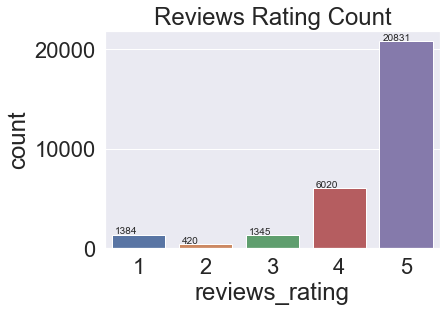

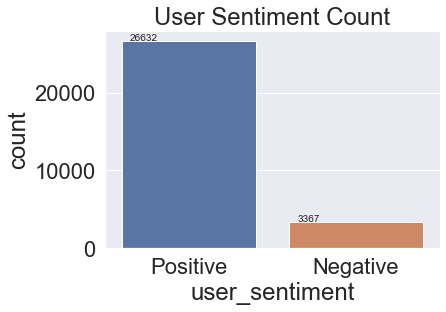

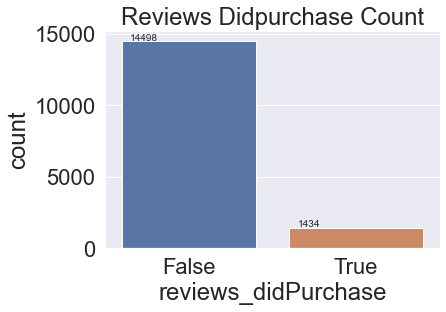

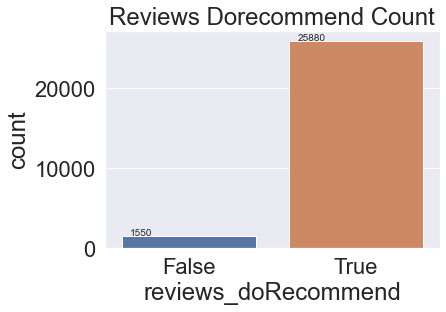

In [1664]:
# Univariate
uni_features = ['reviews_rating', 'user_sentiment', 'reviews_didPurchase', 'reviews_doRecommend']
for feature in uni_features:
    count_chart(df, feature)

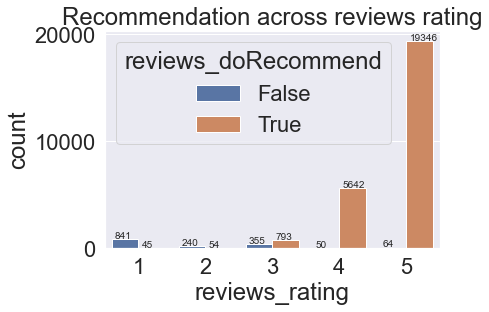

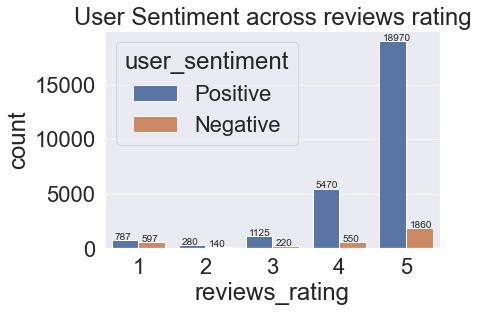

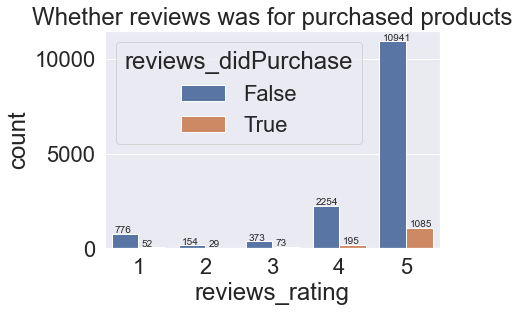

In [1665]:
# Bivariate
count_chart(df, 'reviews_rating', hue='reviews_doRecommend', title='Recommendation across reviews rating')
count_chart(df, 'reviews_rating', hue='user_sentiment', title='User Sentiment across reviews rating')
count_chart(df, 'reviews_rating', hue='reviews_didPurchase', title='Whether reviews was for purchased products')

In [1666]:
# 10 most reviewed manufacturers
df.groupby('manufacturer')['reviews_rating'].agg(['mean', 'count']).sort_values(by='count', ascending=False)[:10]

,mean,count
manufacturer,,
Clorox,4.820501,8546
Test,4.350677,3325
AmazonUs/CLOO7,4.840118,2039
L'oreal Paris,4.017045,1232
Walt Disney,4.677165,1143
Burt's Bees,4.650630,873
SONY CORP,4.674556,845
Twentieth Century Fox,4.303831,757
P&G,4.653425,730


In [1667]:
# 10 most reviewed brands
df.groupby('brand')['reviews_rating'].agg(['mean', 'count']).sort_values(by='count', ascending=False)[:10]

,mean,count
brand,,
Clorox,4.824280,10585
Warner Home Video,4.350677,3325
Disney,4.687500,1200
L'oreal Paris,4.026981,1186
FOX,4.335964,887
Burt's Bees,4.650397,881
Sony Pictures,4.674556,845
Summit Entertainment,4.585486,813
Nexxus,1.359307,693


### Observation
1. With uni-variate analysis:
   - reviews_rating: Majority of the ratings is 5
   - user_sentiment: Majority of the sentiment is positive
   - reviews_didPurchase: Majority of the reviews are from users who did not purchase the product
   - reviews_doRecommend: Positive Recommendation are seen high in the dataset.
2. With bi-variate analysis:
   - reviews_rating v/s reviews_doRecommend: Percentage of negative recommendation for ratings 1 and 2 are more than 80%, while products rated 4 and 5 have very high positive recommendations
   - reviews_rating v/s user_sentiment: Percentage of negative user sentiment is high for ratings 1, 2. Positive user sentiment for ratings 4, 5 are very high.
3. Wordcloud:
   - Perfect, Good, Conditioned, Awesome: are some of the prominent words for reviews rated >3
   - Dissappointed, Irritation: are some of the prominent words for reviews rated <3
4. Clorox, AmazonUs/CLOO7, Walt Disney, Burt's Bees, SONY CORP, P&G are among the top 10 most reviewed and highly rated manufacturers
5. Clorox, Disney, Warner Home Video, Burt's Bees, L'oreal Paris, FOX, Sony Pictures are among the top 10 most reviewed and highly rated brands.

## Data Cleaning and handle Missing Values

In [1668]:
# We can drop the 2 columns reviews_userCity, reviews_userProvince as they have over 90% missing values
# We can also drop reviews_date since that has little importance in analysing user sentiment
# We can also drop reviews_didPurchase since we are not trying to identifying the genuinity of user reviews and there are over 46% missing values

reviews = df.drop(['reviews_userCity', 'reviews_userProvince', 'reviews_date', 'reviews_didPurchase'], axis=1)

In [1669]:
# Check if there are any rows having more than 50% of columns empty?
reviews.loc[reviews.isnull().sum(axis=1) >= 7]

# There are rows that have a maximum of 4 columns that are empty.

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment


In [1670]:
# Drop rows with NA for reviews_username, reviews_doRecommend
reviews = reviews[reviews['reviews_username'].notna()]
reviews = reviews[reviews['reviews_doRecommend'].notna()]

# Lets combine reviews_title and reviews_text to get the entire info.
reviews['reviews_text_title'] = reviews['reviews_title'].fillna('') + ' ' + reviews['reviews_text']

#### Missing Value Treatment -  'manufacturer' column

In [1671]:
reviews[reviews['manufacturer'].isnull()].head(3)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title
22210,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),False,1,I have read the entire Alex Cross series and I...,Disappointing casting,poorcrossing,Negative,Disappointing casting I have read the entire A...
22211,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),False,1,Idris Elba was originally cast in the lead rol...,Atrocious casting,naberios,Positive,Atrocious casting Idris Elba was originally ca...
22212,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),False,2,I was way more excited or this movie than I sh...,Meh,jz30,Positive,Meh I was way more excited or this movie than ...


In [1672]:
missing_manufacturers = reviews[reviews['manufacturer'].isnull()]['brand'].value_counts()
print('Number of manufacturers missing from various brands:\n',missing_manufacturers)

Number of manufacturers missing from various brands:
 Summit Entertainment    141
Name: brand, dtype: int64


In [1673]:
reviews[reviews['manufacturer'] == 'Summit Entertainment'].head(3)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title
5591,AVpf2tw1ilAPnD_xjflC,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),False,2,"Overall a cute tongue in cheek comedy, with so...",Not everything ages gracefully..,nomorepaidreviews,Positive,Not everything ages gracefully.. Overall a cut...
5592,AVpf2tw1ilAPnD_xjflC,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),False,2,Bought this because it was on sale because I e...,So So movie,loki33,Positive,So So movie Bought this because it was on sale...
5593,AVpf2tw1ilAPnD_xjflC,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),False,2,its a ok movie but it was a gift for somebody ...,its a ok movie,ajrespectcosby,Positive,its a ok movie its a ok movie but it was a gif...


In [1674]:
# Impute missing values for manufacturer
reviews.loc[reviews['manufacturer'].isnull(), 'manufacturer'] = 'Summit Entertainment'
print('"manufacturer" - Now has no missing values:')
reviews.isnull().sum()

"manufacturer" - Now has no missing values:


id                      0
brand                   0
categories              0
manufacturer            0
name                    0
reviews_doRecommend     0
reviews_rating          0
reviews_text            0
reviews_title          24
reviews_username        0
user_sentiment          1
reviews_text_title      0
dtype: int64

In [1675]:
# Impute missing values of reviews_doRecommend (Using info from above Bi-variate analysis)
# Since the reviews_doRecommend is False for majority of entries with reviews_rating 1, 2, we can impute the missing entries with False
# for reviews_rating 3,4,5, we can impute with value True

#reviews.loc[(reviews['reviews_doRecommend'].isnull()) & (reviews['reviews_rating'] == 1), 'reviews_doRecommend'] = False
#reviews.loc[(reviews['reviews_doRecommend'].isnull()) & (reviews['reviews_rating'] == 2), 'reviews_doRecommend'] = False
#reviews.loc[(reviews['reviews_doRecommend'].isnull()) & (reviews['reviews_rating'] == 3), 'reviews_doRecommend'] = True
#reviews.loc[(reviews['reviews_doRecommend'].isnull()) & (reviews['reviews_rating'] == 4), 'reviews_doRecommend'] = True
#reviews.loc[(reviews['reviews_doRecommend'].isnull()) & (reviews['reviews_rating'] == 5), 'reviews_doRecommend'] = True

In [1676]:
reviews.head(3)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,Irritation My husband bought this gel for us. ...
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative,Not worth it My boyfriend and I bought this to...


In [1677]:
reviews[reviews['user_sentiment'].isnull()]

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,True,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN,a super hit with my children. they loved it!!?...


In [1678]:
# The missing user sentiment entry is definitely positive from the reviews
reviews.loc[reviews['user_sentiment'].isnull(), 'user_sentiment'] = 'Positive'

In [1679]:
# Lets update the incorrect user_sentiment provided in the dataset.
# We will consider Positive if reviews_doRecommend = True or reviews_rating < 3

def update_sentiment(data):
    if not data['reviews_doRecommend'] or data['reviews_rating'] < 3:
        return 'Negative'
    return 'Positive'

reviews['user_sentiment_mod'] = reviews.apply(lambda x: update_sentiment(x), axis = 1)

In [1680]:
reviews['user_sentiment'].value_counts(), reviews['user_sentiment_mod'].value_counts()

(Positive    24460
 Negative     2936
 Name: user_sentiment, dtype: int64,
 Positive    25747
 Negative     1649
 Name: user_sentiment_mod, dtype: int64)

In [1681]:
# Map 'Positive' sentiment to 1 and 'Negative' sentiment to 0
reviews['user_sentiment_flag'] = reviews['user_sentiment_mod'].map({'Positive': 1, 'Negative': 0})

In [1682]:
reviews.head(3)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title,user_sentiment_mod,user_sentiment_flag
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,Disappointed I read through the reviews on her...,Negative,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,Irritation My husband bought this gel for us. ...,Negative,0
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative,Not worth it My boyfriend and I bought this to...,Negative,0


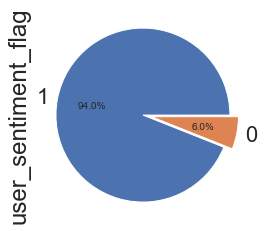

In [1683]:
# This graph shows clear data imbalance
reviews['user_sentiment_flag'].value_counts().plot.pie(autopct="%.1f%%", explode=(0,0.1))
plt.show()

### Observation:
1. Impute 'manufacturer' column <br/>
It can be seen that the categories of missing manufacturers include - "Movies & TV Shows,Instawatch Movies By VUDU etc".<br/>
We can also see that all the missing manufacturers are from brand - 'Summit Entertainment'.<br/>
It can also be seen that 'Summit Entertainment' is also a manufacturer for similar categories.<br/>
Hence We can impute the missing manufacturer with value 'Summit Entertainment'.<br/>
2. Drop rows with null values for reviews_username, reviews_doRecommend, combine reviews_title and reviews_text.
3. Drop columns - 'reviews_userCity', 'reviews_userProvince', 'reviews_date', 'reviews_didPurchase' as they are either having lot of missing values or their presence has little impact in the analysis.
4. Impute the single missing value in user_sentiment with value 'Positive' as its evident from the reviews that the user approves the product.
5. Map the values in user_sentiment to 1 and 0 respectively for 'Positive' and 'Negative'.
6. There is clear class imbalance as seen in above pie chart for user_sentiment_flag.

## Data Pre-Processing

In [1705]:
# Make a copy of reviews dataframe
cleaned_df = reviews.copy()

In [1706]:
def convert_to_lowercase(data, column):
    print('Coverting "{}" to lowercase'.format(column))
    data[column] = data[column].swifter.apply(lambda x: x.lower() if isinstance(x, str) else x)
    return data

In [1707]:
# Convert to lowercase
cols = ['reviews_username', 'reviews_title', 'reviews_text', 'manufacturer', 'brand', 'categories', 'name', 'reviews_text_title']
for col in cols:
    cleaned_df = convert_to_lowercase(cleaned_df, col)

Coverting "reviews_username" to lowercase
Coverting "reviews_title" to lowercase


Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

Coverting "reviews_text" to lowercase


Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

Coverting "manufacturer" to lowercase


Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

Coverting "brand" to lowercase


Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

Coverting "categories" to lowercase


Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

Coverting "name" to lowercase


Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

Coverting "reviews_text_title" to lowercase


Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

In [1734]:
# Tokenize
# punctuation removal
# stopwords removal
# Lemmatize

def preprocess_text(sentence):
    s = set(string.punctuation)
    sentence = tknzr.tokenize(sentence)
    punctuation_removed = [i for i in sentence if i not in s]
    stopwords_removed = [i for i in punctuation_removed if i not in stopwords_list]
    lemmatized_words = [lemmatizer.lemmatize(i, pos='v') for i in stopwords_removed]
    text = re.sub(r"[!\"#$%&\'\(\)\*\+,\-\.\/:;<=>\?@\[\\\]\^_\`{\|}~]", "", " ".join(stopwords_removed))
    return text.strip()

In [1735]:
cleaned_df['cleaned_reviews'] = cleaned_df['reviews_text_title'].swifter.apply(lambda x: preprocess_text(str(x)))

Pandas Apply:   0%|          | 0/27396 [00:00<?, ?it/s]

In [1736]:
positive_reviews = cleaned_df.loc[cleaned_df.user_sentiment_mod=='Positive',['cleaned_reviews']]
negative_reviews = cleaned_df.loc[cleaned_df.user_sentiment_mod=='Negative',['cleaned_reviews']]

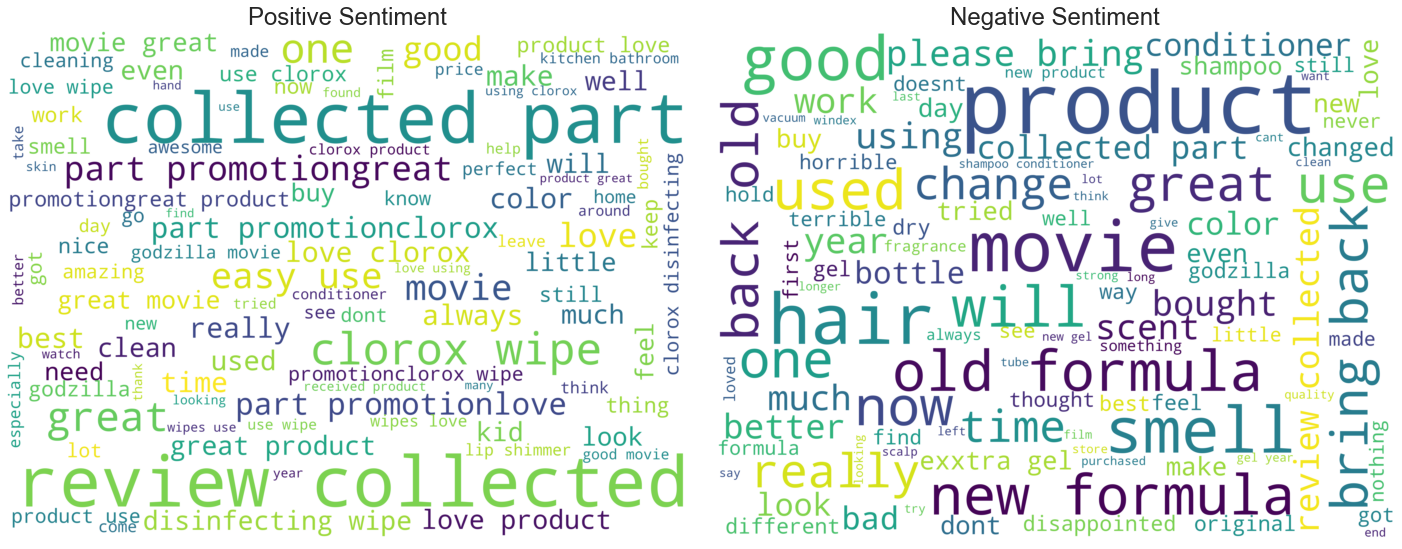

In [1737]:
# Wordcloud to view most prominent words in reviews text
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=100, 
        width=800,
        height=600,
        scale=10,
        random_state=1
).generate(str(data))
    return wordcloud

positive = show_wordcloud(''.join(positive_reviews['cleaned_reviews']), title='Review Text and Title with positive sentiment')
negative = show_wordcloud(''.join(negative_reviews['cleaned_reviews']), title='Review Text and Title with negative sentiment')

sns.set(font_scale=2)
plt.figure(figsize=(20,12))
plt.subplot(1,2,1)
plt.title('Positive Sentiment')
plt.imshow(positive, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('Negative Sentiment')
plt.imshow(negative, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()

plt.show()

### Observation:
1. Pre-processed the text by converting it to lowercase, Tokenised and then performed punctuation removal, stopword removal and lemmatization.
2. Wordcloud showing positive and negative sentiment after cleanup.

## Feature Extraction

In [1752]:
# Define X and y
X = cleaned_df['cleaned_reviews']
y = cleaned_df['user_sentiment_flag']

In [1753]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 100)

In [1754]:
# Bag of words vectorizer
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [1755]:
pd.DataFrame(X_train_bow.toarray(), columns = bow_vectorizer.get_feature_names())

,00,007,01375,0422,0713,079,09,097,10,100,...,zit,zits,zombie,zombies,zombified,zone,zones,zoo,zoom,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1758]:
# TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    tokenizer= word_tokenize,
    ngram_range = (1, 3),
    stop_words = stopwords,
    sublinear_tf = True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

/Users/sunilshivaswamy/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'ca', 'let', 'must', "n't", 'sha', 'wo'] not in stop_words.
  warnings.warn(


We can ignore the above warning as these stop_words are already taken care of.

In [1760]:
pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names())

,0,0 humidity,0 humidity skin,0 makes,0 makes feel,0 o,0 option,0 option product,0 stars,0 stars bring,...,zoo easyfast,zoo easyfast clean,zoo house,zoo house rather,zoom,zoom around,zoom around house,zucchini,zucchini carrots,zucchini carrots banana
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Observation:
- Applied BOW and TFIDF feature extraction methods
- Lets evaluate models with both the methods

#### Save tfidfvectorizer to a pickle file

In [1761]:
# Save the tfidf_vectorizer object
to_pickle("tfidf_vectorizer", tfidf_vectorizer)

## Handle Class Imbalance

In [1762]:
def handle_class_imbalance(X_train, y_train):
    sm = SMOTETomek(random_state=42)
    X_sm, y_sm = sm.fit_resample(X_train, y_train)
    
    print('Shape of X before SMOTE:',X_train.shape) 
    print('Shape of X before SMOTE:',X_sm.shape) 
    
    print('\n')
    
    print('Balance of positive and negative classes before SMOTE:',y_train.value_counts(normalize=True).reset_index())
    print('Balance of positive and negative classes after SMOTE:',y_sm.value_counts(normalize=True).reset_index())
    
    return X_sm, y_sm

print('Handle Class imbalance for BOW model:')
X_sm_train_bow, y_sm_train_bow = handle_class_imbalance(X_train_bow, y_train)

print('\n')

print('Handle Class imbalance for tfidf model:')
X_sm_train_tfidf, y_sm_train_tfidf = handle_class_imbalance(X_train_tfidf, y_train)

Handle Class imbalance for BOW model:
Shape of X before SMOTE: (19177, 14850)
Shape of X before SMOTE: (36000, 14850)


Balance of positive and negative classes before SMOTE:    index  user_sentiment_flag
0      1             0.938833
1      0             0.061167
Balance of positive and negative classes after SMOTE:    index  user_sentiment_flag
0      0                  0.5
1      1                  0.5


Handle Class imbalance for tfidf model:
Shape of X before SMOTE: (19177, 402150)
Shape of X before SMOTE: (36008, 402150)


Balance of positive and negative classes before SMOTE:    index  user_sentiment_flag
0      1             0.938833
1      0             0.061167
Balance of positive and negative classes after SMOTE:    index  user_sentiment_flag
0      0                  0.5
1      1                  0.5


### Observation:
As we can see above the class imbalance was handled.

## Model Building

#### Logistic Regression

In [1763]:
# Evaluation metrics
def print_evaluation_scores(y_test, predicted):
    print('Accuracy : ', accuracy_score(y_test, predicted))
    print('F1 score: ', f1_score(y_test, predicted, average='weighted'))
    print('Recall: ', recall_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('\n')
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, predicted))
    print('\n')

In [1764]:
# Create and fit LogisticRegression wraped into OneVsRestClassifier.
def train_classifier_logistic(X_train, y_train, C, regularisation):
    model = OneVsRestClassifier(LogisticRegression(penalty=regularisation, C=C, max_iter=10000)).fit(X_train, y_train)
    return model

classifier_lr_bow = train_classifier_logistic(X_sm_train_bow, y_sm_train_bow, C = 4, regularisation = 'l2')
classifier_lr_tfidf = train_classifier_logistic(X_sm_train_tfidf, y_sm_train_tfidf, C = 4, regularisation = 'l2')

In [1765]:
y_test_predicted_bow = classifier_lr_bow.predict(X_test_bow)
y_test_predicted_tfidf = classifier_lr_tfidf.predict(X_test_tfidf)

In [1766]:
# Predicted sentiment - Negative
print('Predict sentiment for BOW based model:')
print(X_test.to_list()[2], y_test_predicted_bow[2])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[2], y_test_predicted_tfidf[2])

Predict sentiment for BOW based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1
Predict sentiment for TFIDF based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1


In [1770]:
# Predicted sentiment - Positive
print('Predict sentiment for BOW based model:')
print(X_test.to_list()[60], y_test_predicted_bow[60])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[60], y_test_predicted_tfidf[60])

Predict sentiment for BOW based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 0
Predict sentiment for TFIDF based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 0


In [1771]:
# Evaluation
print('Logistic Regression Evaluation:')
print('='*40, '\n')
print('Prediction for BOW based model:')
print_evaluation_scores(y_test, y_test_predicted_bow)

print('Prediction for TFIDF based model:')
print_evaluation_scores(y_test, y_test_predicted_tfidf)

Logistic Regression Evaluation:

Prediction for BOW based model:
Accuracy :  0.9345419150748266
F1 score:  0.9395371227524063
Recall:  0.9531189461449051
Precision:  0.9768365320979484


Confusion Matrix: 
[[ 301  175]
 [ 363 7380]]


Prediction for TFIDF based model:
Accuracy :  0.9641075556637061
F1 score:  0.9635012933242837
Recall:  0.9830814929613845
Precision:  0.9789094650205762


Confusion Matrix: 
[[ 312  164]
 [ 131 7612]]




#### Naive Bayes

In [1772]:
def train_NB_classifier(X_train, y_train):
    bnb = BernoulliNB()
    # fit 
    bnb.fit(X_train, y_train)
    return bnb


classifier_nb_bow = train_NB_classifier(X_sm_train_bow, y_sm_train_bow)
classifier_nb_tfidf = train_NB_classifier(X_sm_train_tfidf, y_sm_train_tfidf)

y_test_predicted_bow = classifier_nb_bow.predict(X_test_bow)
y_test_predicted_tfidf = classifier_nb_tfidf.predict(X_test_tfidf)

In [1773]:
# Predicted sentiment - Negative
print('Predict sentiment for BOW based model:')
print(X_test.to_list()[2], y_test_predicted_bow[2])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[2], y_test_predicted_tfidf[2])

Predict sentiment for BOW based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1
Predict sentiment for TFIDF based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1


In [1774]:
# Predicted sentiment - Negative
print('Predict sentiment for BOW based model:')
print(X_test.to_list()[60], y_test_predicted_bow[60])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[60], y_test_predicted_tfidf[60])

Predict sentiment for BOW based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 0
Predict sentiment for TFIDF based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 1


In [1775]:
# Evaluation

print('Naive Bayes Evaluation:')
print('='*40, '\n')
print('Prediction for BOW based model:')
print_evaluation_scores(y_test, y_test_predicted_bow)

print('Prediction for TFIDF based model:')
print_evaluation_scores(y_test, y_test_predicted_tfidf)

Naive Bayes Evaluation:

Prediction for BOW based model:
Accuracy :  0.8754106338970677
F1 score:  0.8960588176924333
Recall:  0.8979723621335399
Precision:  0.9674412133017949


Confusion Matrix: 
[[ 242  234]
 [ 790 6953]]


Prediction for TFIDF based model:
Accuracy :  0.9592407835503103
F1 score:  0.9501172092529759
Recall:  0.9979336174609325
Precision:  0.9603529704200845


Confusion Matrix: 
[[ 157  319]
 [  16 7727]]




#### Random Forest

In [1776]:
def train_classifier_randomForest(X_train, y_train):
    model = RandomForestClassifier( max_depth = 15,
    max_features = 10,
    min_samples_leaf = 50,
    min_samples_split = 100,
    n_estimators = 200,
    bootstrap = True,
    n_jobs = -1,
    verbose = 1,
    random_state = 42 )
    model.fit(X_train, y_train)
    return model

classifier_rf_bow = train_classifier_randomForest(X_sm_train_bow, y_sm_train_bow)
classifier_rf_tfidf = train_classifier_randomForest(X_sm_train_tfidf, y_sm_train_tfidf)

y_test_predicted_bow = classifier_rf_bow.predict(X_test_bow)
y_test_predicted_tfidf = classifier_rf_tfidf.predict(X_test_tfidf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

In [1777]:
# Predicted sentiment - Negative

print('Predict sentiment for BOW based model:')
print(X_test.to_list()[2], y_test_predicted_bow[2])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[2], y_test_predicted_tfidf[2])

Predict sentiment for BOW based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1
Predict sentiment for TFIDF based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1


In [1778]:
# Predicted sentiment - Positive

print('Predict sentiment for BOW based model:')
print(X_test.to_list()[60], y_test_predicted_bow[60])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[60], y_test_predicted_tfidf[60])

Predict sentiment for BOW based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 0
Predict sentiment for TFIDF based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 1


In [1779]:
# Evaluation

print('Random Forest Evaluation:')
print('='*40, '\n')
print('Prediction for BOW based model:')
print_evaluation_scores(y_test, y_test_predicted_bow)

print('Prediction for TFIDF based model:')
print_evaluation_scores(y_test, y_test_predicted_tfidf)

Random Forest Evaluation:

Prediction for BOW based model:
Accuracy :  0.7173622095145394
F1 score:  0.7916539021620141
Recall:  0.7285289939300013
Precision:  0.9622995564653701


Confusion Matrix: 
[[ 255  221]
 [2102 5641]]


Prediction for TFIDF based model:
Accuracy :  0.929431804355761
F1 score:  0.9135580846625218
Recall:  0.9821774506005424
Precision:  0.9450726978998385


Confusion Matrix: 
[[  34  442]
 [ 138 7605]]




#### XGBoost

In [1780]:
def train_classifier_xgb(X_train, y_train):
    model = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic')
    model.fit(X_train, y_train)
    return model
    
classifier_xg_bow = train_classifier_xgb(X_sm_train_bow, y_sm_train_bow)
classifier_xg_tfidf = train_classifier_xgb(X_sm_train_tfidf, y_sm_train_tfidf)

y_test_predicted_bow = classifier_xg_bow.predict(X_test_bow)
y_test_predicted_tfidf = classifier_xg_tfidf.predict(X_test_tfidf)

In [1781]:
# Predicted sentiment - Negative
print('Predict sentiment for BOW based model:')
print(X_test.to_list()[2], y_test_predicted_bow[2])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[2], y_test_predicted_tfidf[2])

Predict sentiment for BOW based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1
Predict sentiment for TFIDF based model:
everyday cleaner clorox products always apart familys cleaning routine effective affordable products plainly works review collected part promotion 1


In [1782]:
# Predicted sentiment - Positive (Not predicted correctly)
print('Predict sentiment for BOW based model:')
print(X_test.to_list()[60], y_test_predicted_bow[60])

print('Predict sentiment for TFIDF based model:')
print(X_test.to_list()[60], y_test_predicted_tfidf[60])

Predict sentiment for BOW based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 0
Predict sentiment for TFIDF based model:
bad batch 30years using windex last purchases seems watered  something different formula discount brands work far better  happened 0


In [1783]:
# Evaluation
    
print('XGBoost Evaluation:')
print('='*40, '\n')
print('Prediction for BOW based model:')
print_evaluation_scores(y_test, y_test_predicted_bow)

print('Prediction for TFIDF based model:')
print_evaluation_scores(y_test, y_test_predicted_tfidf)

XGBoost Evaluation:

Prediction for BOW based model:
Accuracy :  0.9645942328750456
F1 score:  0.9603106220340663
Recall:  0.9936717034741056
Precision:  0.9695060483870968


Confusion Matrix: 
[[ 234  242]
 [  49 7694]]


Prediction for TFIDF based model:
Accuracy :  0.95948412215598
F1 score:  0.9545822582039316
Recall:  0.9909595763915795
Precision:  0.9668598790322581


Confusion Matrix: 
[[ 213  263]
 [  70 7673]]




### Observation:
Built 4 models - Logistic Regression, Naive Bayes, Random Forest and XGBoost.

It appears like tfidf based model for Logistic Regression fares better than the rest

In [1784]:
# Lets save the classifier - Logistic Regression BOW based model    
to_pickle("lr_tfidf_model", classifier_lr_tfidf)

## Recommendation System

In [1849]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from numpy import *

In [1850]:
# Copy the cleaned_df
rs_df = cleaned_df.copy()

In [1851]:
# Check for null values
rs_df.isnull().sum(), rs_df.shape

(id                      0
 brand                   0
 categories              0
 manufacturer            0
 name                    0
 reviews_doRecommend     0
 reviews_rating          0
 reviews_text            0
 reviews_title          24
 reviews_username        0
 user_sentiment          0
 reviews_text_title      0
 user_sentiment_mod      0
 user_sentiment_flag     0
 cleaned_reviews         0
 dtype: int64,
 (27396, 15))

In [1852]:
#rs_df[(rs_df['id'] == 'AVpfPPkEilAPnD_xX3cP') & (rs_df['reviews_username'] == 'byamazon customer')]['reviews_rating'].mean()

In [1853]:
# Provide ids for reviews_username
#all_users = rs_df['reviews_username'].unique().tolist()
#all_users_id = range(1,len(all_users)+1)
#rs_df['user_id'] = rs_df['reviews_username'].map(dict(zip(all_users, all_users_id)))

In [1854]:
# Split the Data into train and test
rs_train, rs_test = train_test_split(rs_df, test_size = 0.3, random_state = 100)

In [1855]:
# Shape of train and test
rs_train.shape, rs_test.shape

((19177, 15), (8219, 15))

In [1856]:
# Pivot the data such that rows are reviews_username, cols are name and values are reviews_rating
pivot_rsdf = rs_train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).fillna(0)
pivot_rsdf.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creating dummy train & dummy test dataset
These dataset will be used for prediction

Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [1857]:
# Copy the train dataset into dummy_train
dummy_train = rs_train.copy()

In [1858]:
# The products not rated by user is marked as 1 for prediction
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [1859]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(index='reviews_username', columns='id', values='reviews_rating', aggfunc='mean').fillna(1)
dummy_train.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Using Cosine Similarity

In [1860]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(pivot_rsdf, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [1861]:
user_correlation.shape

(16932, 16932)

### Using Adjusted Cosine Similarity

Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [1862]:
pivot_rsdf = rs_train.pivot_table(index='reviews_username', columns='id', values='reviews_rating', aggfunc='mean')

In [1863]:
pivot_rsdf.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Normalising rating around 0 mean

In [1864]:
mean = np.nanmean(pivot_rsdf, axis=1)
df_subtracted = (pivot_rsdf.T-mean).T

In [1865]:
df_subtracted.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1866]:
# Finding cosine similarity
# Creating the User Similarity Matrix using pairwise_distance function.

user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Prediction - User User

In [1867]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1868]:
# Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation 
# with the product rating (as present in the rating dataset).

user_predicted_ratings = np.dot(user_correlation, pivot_rsdf.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.20651124, 0.        , ..., 0.        , 1.88982237,
        1.93649167],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [1869]:
user_predicted_ratings.shape

(16932, 195)

In [1870]:
# Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero

user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,6.206511,0.0,0.0,0.0,0.269582,0.0,0.0,0.0,0.0,...,0.0,2.350559,0.0,0.0,0.0,0.0,0.0,0.0,1.889822,1.936492
01impala,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


Finding the top 5 recommendation for the user

In [1871]:
# Take username as input

user_input = (input("Enter your user name:"))
print(user_input)

Enter your user name:mike
mike


In [1872]:
user_final_rating.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,6.206511,0.0,0.0,0.0,0.269582,0.0,0.0,0.0,0.0,...,0.0,2.350559,0.0,0.0,0.0,0.0,0.0,0.0,1.889822,1.936492


In [1873]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d.reset_index()

,id,mike
0,AVpf0eb2LJeJML43EVSt,19.241628
1,AVpf2tw1ilAPnD_xjflC,11.054513
2,AV1YGDqsGV-KLJ3adc-O,8.217118
3,AVpf385g1cnluZ0-s0_t,7.278280
4,AVpfM_ytilAPnD_xXIJb,6.692538


### Evaluation - User-User
Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user instead of predicting it for the product not rated by the user.

In [1874]:
# Find out the common users of test and train dataset.
common = rs_test[rs_test.reviews_username.isin(rs_train.reviews_username)]
common.shape

(1756, 15)

In [1875]:
common.head()

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title,user_sentiment_mod,user_sentiment_flag,cleaned_reviews
2962,AVpe59io1cnluZ0-ZgDU,universal home video,"movies, music & books,movies,comedy,movies & t...",universal,my big fat greek wedding 2 (blu-ray + dvd + di...,True,5,this was better than the first. we laughed so ...,funny,sj95123,Positive,funny this was better than the first. we laugh...,Positive,1,funny better first laughed hard fun night
20449,AVpfJP1C1cnluZ0-e3Xy,clorox,"household chemicals,household cleaners,bath & ...",amazonus/cloo7,clorox disinfecting bathroom cleaner,True,5,i really like to have these around the house f...,very convenient,abismomy,Positive,very convenient i really like to have these ar...,Positive,1,convenient really around house easy clean
15168,AVpf4oLxLJeJML43FcxC,avery,"office,office supplies,office organization,bin...",avery dennison,avery174 ready index contemporary table of con...,True,5,i am taking a number of online courses where i...,love this product,oklahomaannie,Positive,love this product i am taking a number of onli...,Positive,1,love product taking number online courses down...
10672,AVpf3VOfilAPnD_xjpun,clorox,"household essentials,cleaning supplies,kitchen...",clorox,clorox disinfecting wipes value pack scented 1...,True,5,i love using clorox disinfecting wipes you can...,this is the best cleaning product i have ever use,nan71,Positive,this is the best cleaning product i have ever ...,Positive,1,best cleaning product use love using clorox di...
15844,AVpf63aJLJeJML43F__Q,burt's bees,"personal care,makeup,lipstick, lip gloss, & li...",burt's bees,"burt's bees lip shimmer, raisin",True,4,why do you keep taking away all the great brow...,disappointing,hazel,Positive,disappointing why do you keep taking away all ...,Positive,1,disappointing keep taking away great brown fam...


In [1876]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [1877]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [1878]:
df_subtracted.head(1)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1879]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,16922,16923,16924,16925,16926,16927,16928,16929,16930,16931
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1880]:
common.head(1)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title,user_sentiment_mod,user_sentiment_flag,cleaned_reviews
2962,AVpe59io1cnluZ0-ZgDU,universal home video,"movies, music & books,movies,comedy,movies & t...",universal,my big fat greek wedding 2 (blu-ray + dvd + di...,True,5,this was better than the first. we laughed so ...,funny,sj95123,Positive,funny this was better than the first. we laugh...,Positive,1,funny better first laughed hard fun night


In [1881]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [1882]:
user_correlation_df_1.shape

(1481, 16932)

In [1883]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [1884]:
user_correlation_df_3 = user_correlation_df_2.T

In [1885]:
user_correlation_df_3.head()

,1234,143st,23jen,4 rooms 1 dog lotsa fur,4cloroxl,4djs,7.87E+11,7inthenest,8ellie24,a hutch,...,wowwie,xavier,xmom,yeya,yoadrian,yohnie1,yummy,zebras,zippy,zitro
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 rooms 1 dog lotsa fur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1886]:
user_correlation_df_3.shape

(1481, 1481)

In [1887]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 8.46157928, 0.        , ..., 0.        , 1.44337567,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [1888]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [1889]:
dummy_test.shape

(1481, 101)

In [1890]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [1891]:
common_user_predicted_ratings.head(2)

name,100:complete first season (blu-ray),"42 dual drop leaf table with 2 madrid chairs""",alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",...,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,tresemme kertatin smooth infusing conditioning,vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1892]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Users/sunilshivaswamy/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/sunilshivaswamy/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [1893]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [1894]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [1895]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

0.5393598899705937


### Item Based Similarity

In [1957]:
#Taking the transpose of the rating matrix to normalize the rating around the mean for different product names. 
# In the user based similarity, we had taken mean for each user instead of each product name.
df_pivot_rs = rs_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot_rs.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,09mommy11,1.11E+24,1085,1143mom,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1958]:
# Normalising the product rating for each product for using the Adujsted Cosine
mean = np.nanmean(df_pivot_rs, axis=1)
df_subtracted = (df_pivot_rs.T-mean).T

In [1959]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,09mommy11,1.11E+24,1085,1143mom,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.058559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1960]:
# Finding the cosine similarity using pairwise distances approach
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.00214912 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.00214912 0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [1961]:
# Filtering the correlation only for which the value is greater than 0. (Positively correlated)
item_correlation[item_correlation<0]=0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.00214912,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.00214912, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Prediction - Item Item

In [1962]:
item_predicted_ratings = np.dot((df_pivot_rs.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03549522, 0.        ,
        0.        ],
       [0.01470543, 0.        , 0.        , ..., 0.        , 0.00265638,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00446105, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0591587 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0089221 , 0.        ,
        0.        ]])

In [1963]:
item_predicted_ratings.shape

(16932, 195)

In [1964]:
dummy_train.shape

(16932, 195)

In [1965]:
# Filtering the rating only for the products not rated by the user for recommendation

item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
00sab00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.007700,0.0,0.0,...,0.000000,0.005612,0.000000,0.020784,0.0,0.0,0.0,0.035495,0.000000,0.0
01impala,0.014705,0.0,0.0,0.0,0.0,0.0,0.0,0.004334,0.0,0.0,...,0.001900,0.001583,0.076575,0.000000,0.0,0.0,0.0,0.000000,0.002656,0.0
02dakota,0.024509,0.0,0.0,0.0,0.0,0.0,0.0,0.007223,0.0,0.0,...,0.003167,0.002638,0.127625,0.000000,0.0,0.0,0.0,0.000000,0.004427,0.0
02deuce,0.019607,0.0,0.0,0.0,0.0,0.0,0.0,0.005778,0.0,0.0,...,0.002534,0.002111,0.102100,0.000000,0.0,0.0,0.0,0.000000,0.003542,0.0


In [1966]:
# Finding the top 5 recommendation for the user

# Take the user name as input
user_input = input("Enter your user name")
print(user_input)

Enter your user namemike
mike


In [1967]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d.reset_index()

,id,mike
0,AVpfEqruilAPnD_xUWDr,0.714527
1,AVpfD9xTLJeJML431ig2,0.335016
2,AVpfJcHuLJeJML433ZrY,0.315297
3,AVpf5olc1cnluZ0-tPrO,0.214157
4,AVpe7sl91cnluZ0-aI1Y,0.187120


### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user instead of predicting it for the product not rated by the user.

In [1968]:
common =  rs_test[rs_test.name.isin(rs_train.name)]
common.shape

(8199, 15)

In [1969]:
common.head(4)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_title,user_sentiment_mod,user_sentiment_flag,cleaned_reviews
2962,AVpe59io1cnluZ0-ZgDU,universal home video,"movies, music & books,movies,comedy,movies & t...",universal,my big fat greek wedding 2 (blu-ray + dvd + di...,True,5,this was better than the first. we laughed so ...,funny,sj95123,Positive,funny this was better than the first. we laugh...,Positive,1,funny better first laughed hard fun night
15033,AVpf4oLxLJeJML43FcxC,avery,"office,office supplies,office organization,bin...",avery dennison,avery174 ready index contemporary table of con...,True,4,these ready index dividers are one of the best...,ready index divider products,gustavwoodman,Positive,ready index divider products these ready index...,Positive,1,ready index divider products ready index divid...
13605,AVpf3VOfilAPnD_xjpun,clorox,"household essentials,cleaning supplies,kitchen...",clorox,clorox disinfecting wipes value pack scented 1...,True,5,clorox products have always been apart of our ...,my everyday cleaner,sammiejojo,Positive,my everyday cleaner clorox products have alway...,Positive,1,everyday cleaner clorox products always apart ...
25749,AVpfPaoqLJeJML435Xk9,warner home video,"movies, music & books,movies,action & adventur...",test,godzilla 3d includes digital copy ultraviolet ...,True,5,this was a good 3d movie. plenty of action and...,good 3d movie.,jb1234,Positive,good 3d movie. this was a good 3d movie. plent...,Positive,1,good 3d movie good 3d movie plenty action dece...


In [1970]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [1971]:
common_item_based_matrix.shape

(141, 7673)

In [1972]:
item_correlation_df = pd.DataFrame(item_correlation)

In [1973]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1974]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002149,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [1975]:
list_name = common.id.tolist()

In [1976]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [1977]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [1978]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,...,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002149
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [1979]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01115262, 0.01115262, 0.        , ..., 0.        , 0.01115262,
        0.01115262],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [1980]:
common_item_predicted_ratings.shape

(141, 7673)

In [1981]:
# Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user.
# So, this is marked as 1. This is just opposite of dummy_train

dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [1982]:
# The products not rated is marked as 0 for evaluation. And make the item-item matrix representaion.

common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [1983]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Users/sunilshivaswamy/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/sunilshivaswamy/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [1984]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [1985]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5773672260675657


### Observation
1. Performed 2 types of recommendation systems:
    a. User-User based
    b. Item-Item based
2. After computing rmse for both it was found that:
   User-User based with rmse of '0.53' was found to be better than Item-Item based system with rmse of '3.57'

In [1986]:
# Lets save the Recommendation filter - User-User based model    
to_pickle("user_user_recommend", user_final_rating)

### Recommend Top 20 products for a user

In [2077]:
# Take username as input
user_input = input("Enter Username: ")

Enter Username: 1hotmama


In [2078]:
# Get dataframe containing unique id, name values
product_id_map = cleaned_df[['id', 'name']]
product_id_map = product_id_map.drop_duplicates()
product_id_map.head(3)

,id,name
3,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel
31,AV1d76w7vKc47QAVhCqn,"j.r. watkins hand cream, lemon cream"
36,AV1h6gSl-jtxr-f31p40,ambi complexion cleansing bar


#### Top 20 recommendations for the user

In [2079]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
top20 = pd.merge(d, product_id_map, left_on = 'id', right_on = 'id', how = 'left')
top20

,id,1hotmama,name
0,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel
1,AVpfUJu_ilAPnD_xZdDr,0.0,chobani174 strawberry on the bottom non-fat gr...
2,AVpfNVsj1cnluZ0-gNQN,0.0,physicians formula powder palette mineral glow...
3,AVpfNWbPilAPnD_xXPR7,0.0,"pleasant hearth 7.5 steel grate, 30 5 bar - black"
4,AVpfNfEMLJeJML434uf-,0.0,heiress (dvd)
5,AVpfO5u71cnluZ0-guiN,0.0,switchmas (dvd)
6,AVpfOIrkilAPnD_xXgDG,0.0,alex cross (dvdvideo)
7,AVpfOfIqLJeJML435D06,0.0,solo foods poppy seed cake and pastry filling
8,AVpfOmKwLJeJML435GM7,0.0,clear scalp & hair therapy total care nourishi...
9,AVpfPPkEilAPnD_xX3cP,0.0,aveeno baby continuous protection lotion sunsc...


#### Improving recommendations using the Sentiment Analysis model

In [2080]:
merged_top_20 = pd.merge(top20, cleaned_df[['id', 'cleaned_reviews']], left_on='id', right_on='id', how='left')
merged_top_20

,id,1hotmama,name,cleaned_reviews
0,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,disappointed read reviews looking buying one c...
1,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,irritation husband bought gel us gel caused ir...
2,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,not worth boyfriend bought spice things bedroo...
3,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,disappointing bought earlier today excited che...
4,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,not happy bought product husband try not impre...
...,...,...,...,...
5404,AVpfRYbSilAPnD_xYkD4,0.0,shea moisture mango & carrot kids extra-nouris...,effective smells great conditioner absolutely ...
5405,AVpfRYbSilAPnD_xYkD4,0.0,shea moisture mango & carrot kids extra-nouris...,moisturizing adult enjoy hair moisturizer
5406,AVpfRYbSilAPnD_xYkD4,0.0,shea moisture mango & carrot kids extra-nouris...,helped smooth babies broken locks baby fine br...
5407,AVpfRkzN1cnluZ0-hmnu,0.0,smead174 2 1/4 inch accordion expansion wallet...,safe strong protect important receipts hand de...


In [2081]:
# transform using the vecotrizer and predict using LR model
tfidf_top20 = tfidf_vectorizer.transform(merged_top_20['cleaned_reviews'])
predicted_sentiments = classifier_lr_tfidf.predict(tfidf_top20)
predicted_sentiments = pd.DataFrame(predicted_sentiments, columns = ['predicted_sentiment'])
predicted_sentiments

,predicted_sentiment
0,0
1,0
2,0
3,0
4,0
...,...
5404,1
5405,1
5406,1
5407,1


In [2082]:
recommended = pd.concat([merged_top_20, predicted_sentiments], axis=1)
recommended

,id,1hotmama,name,cleaned_reviews,predicted_sentiment
0,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,disappointed read reviews looking buying one c...,0
1,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,irritation husband bought gel us gel caused ir...,0
2,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,not worth boyfriend bought spice things bedroo...,0
3,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,disappointing bought earlier today excited che...,0
4,AV16khLE-jtxr-f38VFn,0.0,k-y love sensuality pleasure gel,not happy bought product husband try not impre...,0
...,...,...,...,...,...
5404,AVpfRYbSilAPnD_xYkD4,0.0,shea moisture mango & carrot kids extra-nouris...,effective smells great conditioner absolutely ...,1
5405,AVpfRYbSilAPnD_xYkD4,0.0,shea moisture mango & carrot kids extra-nouris...,moisturizing adult enjoy hair moisturizer,1
5406,AVpfRYbSilAPnD_xYkD4,0.0,shea moisture mango & carrot kids extra-nouris...,helped smooth babies broken locks baby fine br...,1
5407,AVpfRkzN1cnluZ0-hmnu,0.0,smead174 2 1/4 inch accordion expansion wallet...,safe strong protect important receipts hand de...,1


In [2083]:
popular_percentage = round((recommended.groupby('id')['predicted_sentiment'].sum() / recommended.groupby('id')['predicted_sentiment'].count()) * 100, 2)
sorted_recommendations = recommended.groupby('id')['predicted_sentiment'].count().sort_values(ascending=False)


In [2084]:
review_count_percentage = pd.merge(sorted_recommendations, popular_percentage, left_on='id', right_on='id', how='left')
review_count_percentage = review_count_percentage.rename(columns = {'predicted_sentiment_x': 'ReviewsCount', 'predicted_sentiment_y':'Positive_sentiment_rate'})
review_count_percentage

,ReviewsCount,Positive_sentiment_rate
id,,
AVpfPaoqLJeJML435Xk9,3325,92.99
AVpfRTh1ilAPnD_xYic2,1142,98.51
AVpfOmKwLJeJML435GM7,260,58.46
AVpfR5m0LJeJML436K3W,201,97.51
AVpfPnrU1cnluZ0-g9rL,186,98.92
AVpfOIrkilAPnD_xXgDG,141,92.91
AVpfQtEm1cnluZ0-hUpe,27,96.30
AV16khLE-jtxr-f38VFn,25,36.00
AVpfUJu_ilAPnD_xZdDr,25,92.00


In [2085]:
final_recommendation = pd.merge(review_count_percentage, product_id_map, left_on='id', right_on='id', how='left')
final_recommendation

,id,ReviewsCount,Positive_sentiment_rate,name
0,AVpfPaoqLJeJML435Xk9,3325,92.99,godzilla 3d includes digital copy ultraviolet ...
1,AVpfRTh1ilAPnD_xYic2,1142,98.51,planes: fire rescue (2 discs) (includes digita...
2,AVpfOmKwLJeJML435GM7,260,58.46,clear scalp & hair therapy total care nourishi...
3,AVpfR5m0LJeJML436K3W,201,97.51,jason aldean - they don't know
4,AVpfPnrU1cnluZ0-g9rL,186,98.92,stargate (ws) (ultimate edition) (director's c...
5,AVpfOIrkilAPnD_xXgDG,141,92.91,alex cross (dvdvideo)
6,AVpfQtEm1cnluZ0-hUpe,27,96.30,jolly time select premium yellow pop corn
7,AV16khLE-jtxr-f38VFn,25,36.00,k-y love sensuality pleasure gel
8,AVpfUJu_ilAPnD_xZdDr,25,92.00,chobani174 strawberry on the bottom non-fat gr...
9,AVpfPPkEilAPnD_xX3cP,19,100.00,aveeno baby continuous protection lotion sunsc...


#### Filter out the top 5 products with the highest percentage of positive reviews

In [2071]:
final_recommendation[final_recommendation['Positive_sentiment_rate'] > final_recommendation['Positive_sentiment_rate'].mean()].head(5)

,id,ReviewsCount,Positive_sentiment_rate,name
0,AVpf0eb2LJeJML43EVSt,844,97.63,the resident evil collection 5 discs (blu-ray)
1,AVpf63aJLJeJML43F__Q,794,94.96,"burt's bees lip shimmer, raisin"
2,AVpf2tw1ilAPnD_xjflC,669,98.06,red (special edition) (dvdvideo)
5,AVpfM_ytilAPnD_xXIJb,264,93.56,tostitos bite size tortilla chips
6,AVpe31o71cnluZ0-YrSD,244,90.57,dark shadows (includes digital copy) (ultravio...


In [2039]:
# Lets save the data frames   
to_pickle("cleaned_df", cleaned_df)
to_pickle("product_id_map", product_id_map)